In [1]:
from google.colab import drive 
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
import os
os.getcwd()
# Change directory for nicer imports
%cd "/content/gdrive/My Drive/Data_Mining_Cup/05 Code/"

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from os import listdir
from os.path import isfile, join


info = pd.read_csv('/content/gdrive/My Drive/Data_Mining_Cup/02 Data/DMC20_Data/infos.csv', delimiter='|', index_col="itemID")
items = pd.read_csv('/content/gdrive/My Drive/Data_Mining_Cup/02 Data/DMC20_Data/items.csv', delimiter='|', index_col="itemID")
orders = pd.read_csv('/content/gdrive/My Drive/Data_Mining_Cup/02 Data/DMC20_Data/orders.csv', delimiter='|', parse_dates=True)

/content/gdrive/My Drive/Data_Mining_Cup/05 Code


In [3]:
end_of_june = True
if end_of_june:
  test_period_start = pd.to_datetime("2018-06-16")
  test_period_end = pd.to_datetime("2018-06-29")
  submission_path = "./model_submissions/submission_end_june"
else:
  test_period_start = pd.to_datetime("2018-06-02")
  test_period_end = pd.to_datetime("2018-06-15")
  submission_path = "./model_submissions"

print(test_period_start, test_period_end, submission_path)

2018-06-16 00:00:00 2018-06-29 00:00:00 ./model_submissions/submission_end_june


# Submission tool

This is our little tool for comparing the different models. The submission files will be be directly taken from ur root folder of the respective team. In the later competition it is only needed to predict the full numbers of orders.

For this submission tool, u can on the one hand submit the demand for the whole time period and/or on the other hand the predictions for the 14 days between 2.6.2018 and 15.06.2018.
In case your team does the last, we are able to compare plots per day. 

The structure of the data looks the following: 

**ItemIDs** as the index of the dataframe.

**demand** as a column, describing the cumulative demand. If the column is not given the tool will simply sum the demands of the respective days.

**dates** according to the following time_range for each of the 14 days. 

The following code will create a sample submission file.

In [4]:
time_range = list(map(lambda x: str(x), pd.date_range( end=test_period_end, periods=14)))
sample_submission = pd.DataFrame(index = items.index, columns = ['demandPrediction', *time_range])
sample_submission.to_csv('sample_submission.csv', sep='|')

To run the comparison, just go through all of the notebook. In case of questions or others, just write me (Markus) on slack and we'll see how we get it to run :)

**Good Luck**

## Preparing data

###Evaluation
The solutions submitted will be assessed and compared on the basis of their monetary value
for the retailer. The monetary value is determined by the predicted revenue and an
overstocking fee for overestimating the demand for any products. The demand prediction
for every product is therefore compared with the actual number of orders within the same
time frame.

If the demand is predicted correctly, the monetary value for that product is simply the
revenue (i.e. price x demandPrediction). If the prediction is lower than the actual number of
units sold, we assume that only the number of predicted stocks for this product will be
available and the company will fail to generate the potential revenue. As a result, the
monetary value is once again the revenue (i.e. price x demandPrediction).

If the __demand
prediction is higher than the actual number of units sold__, we assume that the remaining stock
will generate an overstocking fee of 0.6 x price x (orders - demandPrediction).
The total revenue minus the additional costs for stock clearance is the monetary value of
the solution that is submitted.

The winning team is the one whose solution achieves the highest monetary value. In the
event of a dead heat, a random draw will decide which team wins.

Creation of the solution. 

_inclusive_ **START DATE**: 2018-06-02

_inclusive_ **END DATE**: 2018-06-15

In [5]:
orders['time'] = pd.to_datetime(orders['time'])
orders['date'] = orders['time'].dt.date
solution= orders[['date', 'itemID','order']].groupby(['date', 'itemID']).sum()
solution = solution[solution.index.get_level_values(0) >= test_period_start]
solution = solution[solution.index.get_level_values(0) <= test_period_end]
solution = solution.groupby(solution.index.get_level_values(1)).sum()
solution

,order
itemID,
1,3
3,140
4,145
5,1
7,1
...,...
10438,21
10439,15
10440,21


In [6]:
sol2 = orders[['date','itemID','order']]
sol2 = sol2[sol2['date'] >= test_period_start][sol2['date'] <= test_period_end]
sol2.groupby('itemID').sum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,order
itemID,
1,3
3,140
4,145
5,1
7,1
...,...
10438,21
10439,15
10440,21


In [7]:
# max_possible_mon_value = solution.order * info.simulationPrice
max_possible_mon_value = solution.order.multiply(info.simulationPrice, fill_value=0).sum()

In [8]:
def calculate_monetary_value(submission_df):
  if submission_df is None:
    return None, None

  assert solution is not None, "The solution was not yet calculated. Please run the 'preparing data' part (again) :) Thank uuu"

  # Create new column
  df= submission_df.copy()
  df['monetary_value'] = np.NaN
  df['orders'] = solution['order']
  df['orders'] = df['orders'].fillna(0)
  # Ordinal variable if damand is greater equals orders
  demand_gt_actual= (df['demandPrediction'] >= df['orders']).astype(int)
  difference = df['orders']- df['demandPrediction']
  sales =(df['demandPrediction'] * info['simulationPrice']) 

  df['monetary_value'] = \
    (1-demand_gt_actual)*sales +  demand_gt_actual * df['orders'] * info['simulationPrice'] + demand_gt_actual * (0.6 * info['simulationPrice'] * difference)

  df['difference'] = df['demandPrediction']-df['orders']
  df['sim_price'] = info['simulationPrice']
  return df[['demandPrediction','orders','difference','monetary_value','sim_price']], round(sum(df['monetary_value']), 2)

def preprocess_submission(team: str, submission_df):
  if submission_df is None:
    return
  if 'demandPrediction' not in submission_df or submission_df['demandPrediction'].isnull().values.any():
    if team is not None:
      print(f"The cummulative prediction for team {team} was not given by the team. Will calculate the demand now")

    submission_df['demandPrediction'] = np.NaN
    submission_df['demandPrediction'] = submission_df.drop('demandPrediction',axis=1).sum(axis=1)

  return submission_df

def calculate_monetary_value2(submission_df):
  """
  Mins calculation of Monetary value
  """
  print(solution)
  submission_df['simulationPrice'] = info['simulationPrice']
  submission_df['true_demand'] = solution['order']

  mask1 = submission_df['demandPrediction'] <= sample_submission['true_demand']  # Predict too few
  mask2 = submission_df['demandPrediction'] > sample_submission['true_demand']  # Predict too much

  revenue = np.empty_like(submission_df['demandPrediction'])
  revenue[mask1] = submission_df['simulationPrice'][mask1] * submission_df['demandPrediction'][mask1]
  revenue[mask2] = submission_df['simulationPrice'][mask2] * (1.6 * submission_df['true_demand'][mask2] - 0.6 * submission_df['demandPrediction'][mask2])

  total_revenue = revenue.sum()

  return total_revenue

  

## Prepare Evaluation

Only _csv_ files will be loaded.


In [9]:
subfiles = list(filter(lambda x: x[-4:] == ".csv", [f for f in listdir(submission_path) if isfile(join(submission_path, f))]))

In [10]:
subfiles

['submission_XGBoost_final_k_promo_final_end_june.csv',
 'submission_XGBoost_final_k_promo_final.csv',
 'submission_XGBoost_final_k_promo_final (1).csv',
 'submission_XGBoost_final_2.csv',
 'submission_XGBoost_split_final_k_promo_fast.csv']

In [11]:
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [12]:
submissions = {}
submissions_monet_val = {}
submissions_analysis ={}

_loaded = 0
for f in subfiles:
  print(f"> Load file {f}")
  try:
    submissions[f[:-4]] = pd.read_csv(f'{submission_path}/{f}',delimiter='|', index_col="itemID")
    assert not((submissions[f[:-4]]<0).any().any()), f"The submission {f} has Negative valus"
    _loaded +=1
    print(f"------>submission for model {f[:-4]} loaded.")
  except Exception as e:
    print(f"!!! -->submission file {f} could not be loaded. Because {e}")
print(f"{_loaded} submissions loaded")
del _loaded

> Load file submission_XGBoost_final_k_promo_final_end_june.csv
------>submission for model submission_XGBoost_final_k_promo_final_end_june loaded.
> Load file submission_XGBoost_final_k_promo_final.csv
!!! -->submission file submission_XGBoost_final_k_promo_final.csv could not be loaded. Because The submission submission_XGBoost_final_k_promo_final.csv has Negative valus
> Load file submission_XGBoost_final_k_promo_final (1).csv
------>submission for model submission_XGBoost_final_k_promo_final (1) loaded.
> Load file submission_XGBoost_final_2.csv
------>submission for model submission_XGBoost_final_2 loaded.
> Load file submission_XGBoost_split_final_k_promo_fast.csv
------>submission for model submission_XGBoost_split_final_k_promo_fast loaded.
4 submissions loaded


In [13]:
for sub_key in submissions.keys():
  submissions[sub_key] = preprocess_submission(sub_key, submissions[sub_key])
  submissions_analysis[sub_key], submissions_monet_val[sub_key] = calculate_monetary_value(submissions[sub_key])
  # print(calculate_monetary_value2(submissions[sub_key]))

# Comparison of Submissions


0


([0, 1, 2, 3, 4, 5], <a list of 6 Text major ticklabel objects>)

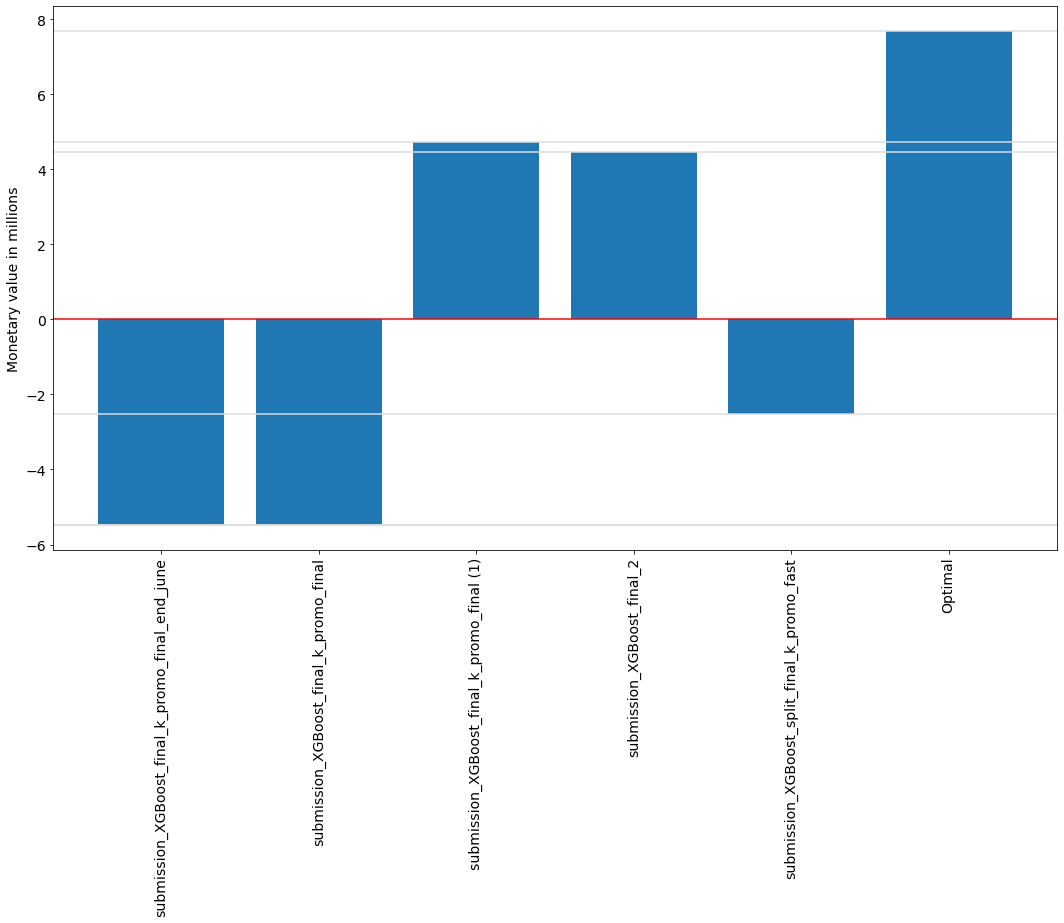

In [14]:
columns = [*submissions_monet_val.keys(), 'Optimal']

mil = 1000000
solution_metrics = [*list(map(lambda x: x/mil, submissions_monet_val.values())), max_possible_mon_value/mil]
print(list((np.array(solution_metrics) < -1000)).index(False))
# for i in range(0, len(solution_metrics)-1):
#   if solution_metrics[i]<-100:
#     print(f"Deleting {columns[i]} because it would make others invisible")
#     solution_metrics.pop(i)
    # columns.pop(i)

plt.bar(columns, solution_metrics)
plt.axhline(y=0, color='red')
for i in solution_metrics:
  plt.axhline(y=i, color='#DDD')
plt.ylabel("Monetary value in millions", fontsize=14)
plt.gcf().set_size_inches((18, 10))
plt.tick_params(labelsize=14)
plt.xticks(rotation=90)

In [15]:
# # Create plot for final presentation manually:
# solution_metrics_1 = [-8,0.9,1.6]
# plt.bar(["seq2seq","CatBoost","XGBoost"], solution_metrics_1)
# plt.axhline(y=0, color='red')
# for i in solution_metrics_1:
#   plt.axhline(y=i, color='#DDD')
# plt.ylabel("Monetary value in millions", fontsize=30)
# plt.gcf().set_size_inches((20, 15))
# plt.tick_params(labelsize=30)


In [16]:
compare_sub = pd.DataFrame(solution_metrics, index=columns, columns=["Monetary Value"])
compare_sub.style.apply(highlight_max)

,Monetary Value
submission_XGBoost_final_k_promo_final_end_june,-5.485261
submission_XGBoost_final_k_promo_final,-5.483603
submission_XGBoost_final_k_promo_final (1),4.725603
submission_XGBoost_final_2,4.471186
submission_XGBoost_split_final_k_promo_fast,-2.522093
Optimal,7.683293


# Submission Analysis

Please specify which model should be analysed. Set the following variable to the csv filename. ```sample_submission.csv``` would end in the value : ```sample_submission```. The following values are showing all possible submissions.

In [17]:
" | ".join(submissions_analysis.keys())

'submission_XGBoost_final_k_promo_final_end_june | submission_XGBoost_final_k_promo_final | submission_XGBoost_final_k_promo_final (1) | submission_XGBoost_final_2 | submission_XGBoost_split_final_k_promo_fast'

In [18]:
submission_to_analyse: str = 'submission_XGBoost_final_k_promo_final (1)'

### Monetary Value

In [19]:
print(f"Monetary value of model {submission_to_analyse} is : {submissions_monet_val[submission_to_analyse]}")

Monetary value of model submission_XGBoost_final_k_promo_final (1) is : 4725603.17


### Descriptive analysis of submissions

This values reflect the monetary value of each item. The mean for example describes the mean of monetary values over all the items

In [20]:
submissions_analysis[submission_to_analyse].describe()

,demandPrediction,orders,difference,monetary_value,sim_price
count,10463.000000,10463.000000,10463.000000,10463.000000,10463.000000
mean,22.172035,28.530154,-6.358119,451.648970,122.010808
std,83.559828,117.841886,65.926966,2217.204218,469.701306
min,0.000000,0.000000,-2420.000000,-15478.650000,0.380000
25%,0.000000,0.000000,-1.000000,0.000000,8.990000
50%,0.000000,0.000000,0.000000,0.000000,23.830000
75%,2.000000,3.000000,0.000000,24.988000,63.125000
max,1940.000000,3457.000000,885.000000,70159.614000,9055.070000


### First prediction

In [21]:
submissions_analysis[submission_to_analyse][30:]

,demandPrediction,orders,difference,monetary_value,sim_price
itemID,,,,,
31,1,1.0,0.0,14.12,14.12
32,0,1.0,-1.0,0.00,32.09
33,0,0.0,0.0,0.00,44.12
34,0,0.0,0.0,0.00,80.28
35,1,1.0,0.0,337.84,337.84
...,...,...,...,...,...
10459,0,0.0,0.0,0.00,14.71
10460,0,0.0,0.0,0.00,325.67
10461,0,0.0,0.0,0.00,190.53


In [22]:
t = submissions_analysis[submission_to_analyse]
t[t.difference < -100]

,demandPrediction,orders,difference,monetary_value,sim_price
itemID,,,,,
393,293,648.0,-355.0,15953.85,54.45
1190,26,143.0,-117.0,186.68,7.18
1866,1,145.0,-144.0,87.17,87.17
1867,1,181.0,-180.0,11.79,11.79
1870,0,151.0,-151.0,0.00,48.11
...,...,...,...,...,...
8614,516,654.0,-138.0,923.64,1.79
8656,592,754.0,-162.0,1219.52,2.06
8701,0,812.0,-812.0,0.00,10.52


In [23]:
t

,demandPrediction,orders,difference,monetary_value,sim_price
itemID,,,,,
1,3,3.0,0.0,10.29,3.43
2,0,0.0,0.0,0.00,9.15
3,120,140.0,-20.0,1684.80,14.04
4,74,145.0,-71.0,1043.40,14.10
5,1,1.0,0.0,7.48,7.48
...,...,...,...,...,...
10459,0,0.0,0.0,0.00,14.71
10460,0,0.0,0.0,0.00,325.67
10461,0,0.0,0.0,0.00,190.53


## Histogramm
of the monetary value


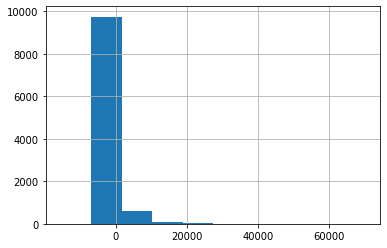

In [24]:
submissions_analysis[submission_to_analyse]['monetary_value'].hist()

historgramm on the difference

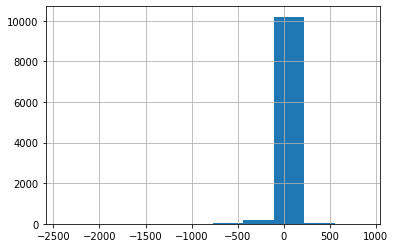

In [25]:
submissions_analysis[submission_to_analyse]['difference'].hist()

## Plot of difference per Item ID


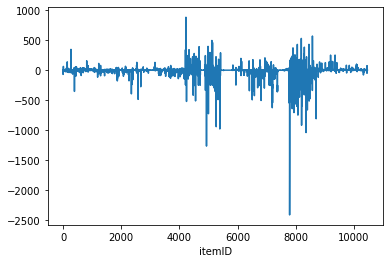

In [26]:
submissions_analysis[submission_to_analyse]['difference'].plot()

# Increase dpi

In [27]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

# Plot predictions vs demand

In [47]:
darkblue = "#005293"
lightblue = "#64a0c8"
lighterblue = "#98c6ea"
gray = "#999999"
orange = "#e37222"
green = "#a2ad00"
lightgray = "#dad7cb"

In [28]:
# predicted = submissions_analysis[submission_to_analyse]['demandPrediction']
# demand = submissions_analysis[submission_to_analyse]['orders']

# joined = pd.concat([predicted, demand], axis=1)

joined = submissions_analysis[submission_to_analyse][['demandPrediction', 'orders']]

In [29]:
joined = joined[(joined.demandPrediction > 0) | (joined.orders > 0)]

In [30]:
joined.shape

(4774, 2)

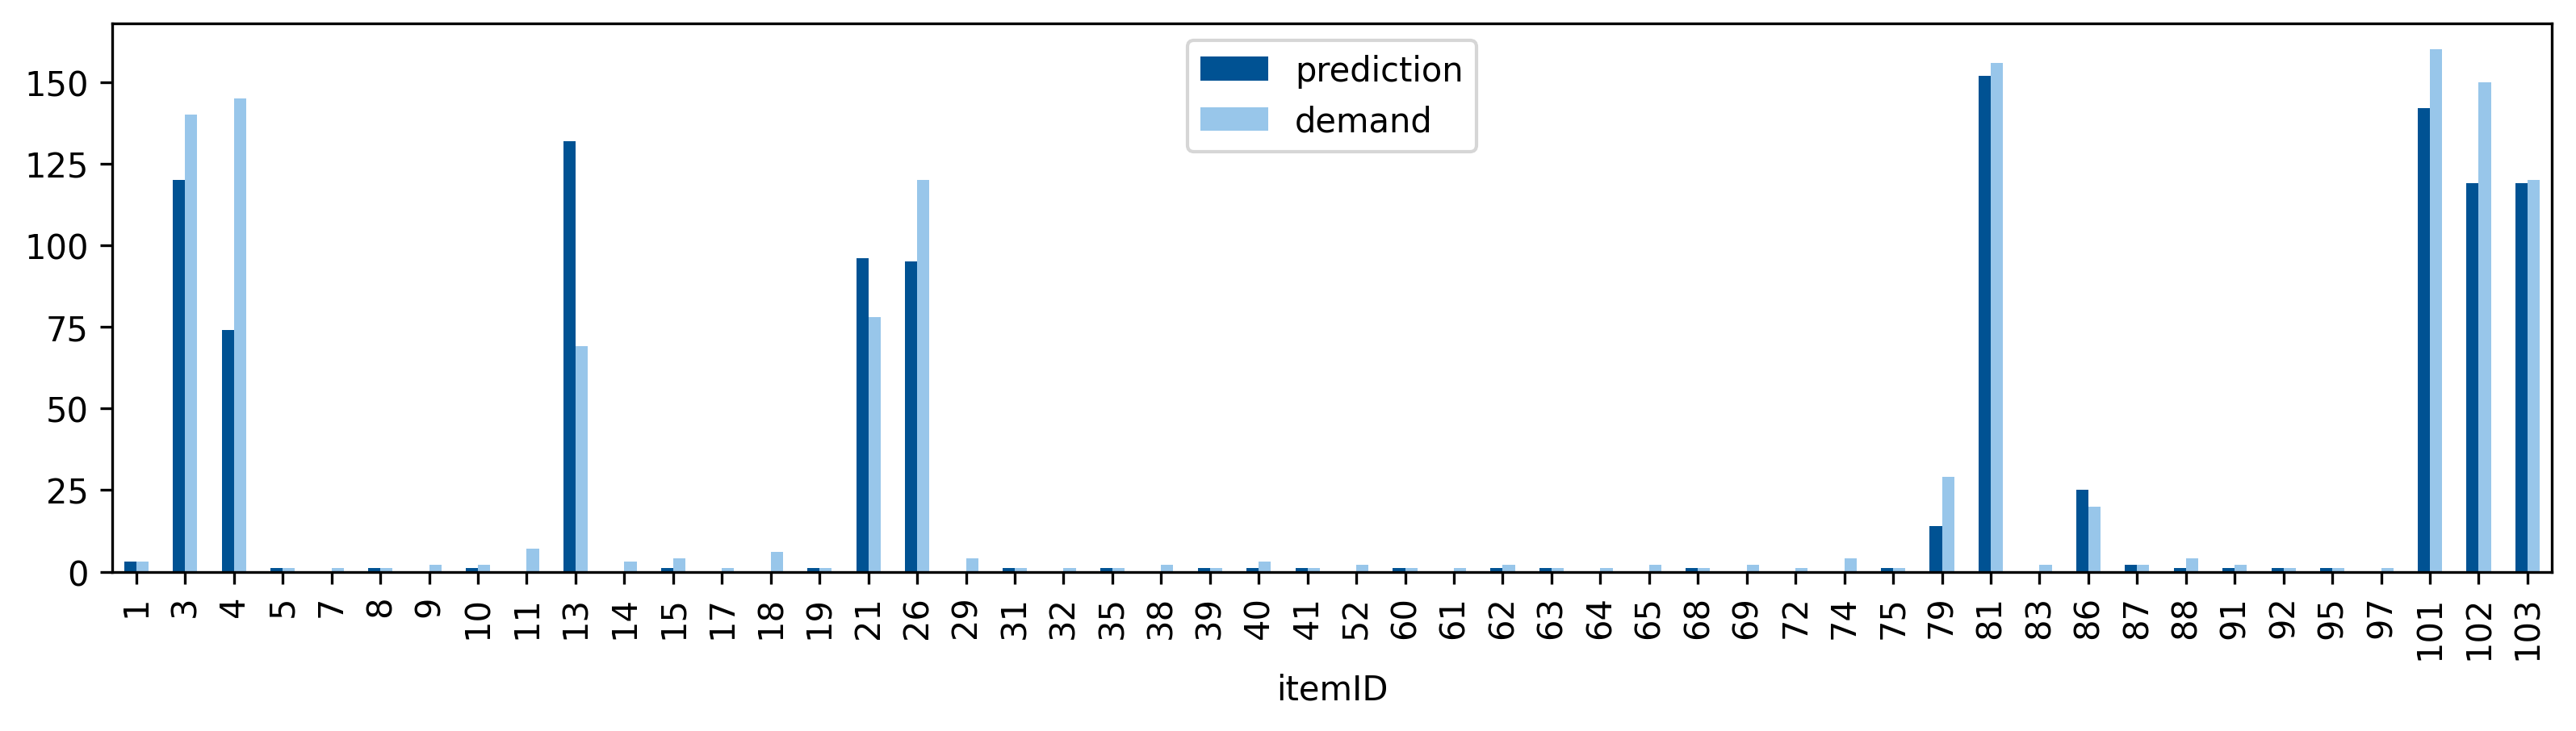

In [51]:
start = 0
size = 50
joined[start:start+size].plot(kind='bar', figsize=(13, 3), color=[darkblue, lighterblue]).legend(loc='upper center', labels=["prediction", "demand"])

In [32]:
# width = 1
# x = np.arange(len(submissions_analysis[submission_to_analyse]['demandPrediction']))

# fig, ax = plt.subplots()
# ax.bar(x - width/2, submissions_analysis[submission_to_analyse]['demandPrediction'], width, label='Prediction')
# ax.bar(x + width/2, submissions_analysis[submission_to_analyse]['orders'], width, label='Demand')

# ax.legend()

## Some random stuff for checking when an item was promoted

In [33]:
tmp = pd.read_pickle('./data/dynamic_features_nb2.pk')

In [34]:
tmp[tmp.promoted > 0].head(90)

order  salesPrice  ...  order_t-13  order_t-14
itemID date                           ...                        
1      2018-01-29  307.0        3.11  ...         0.0         0.0
       2018-02-19   27.0        3.11  ...         0.0         0.0
       2018-04-23  294.0        3.11  ...         0.0         0.0
       2018-05-24   30.0        3.11  ...         0.0         0.0
3      2018-01-18   89.0        9.89  ...         0.0         0.0
...                  ...         ...  ...         ...         ...
40     2018-04-22    5.0      804.57  ...         0.0         0.0
       2018-04-24    8.0      804.57  ...         0.0         0.0
       2018-05-08    5.0      804.57  ...         0.0         8.0
       2018-05-17    5.0      804.57  ...         0.0         0.0
41     2018-01-07   11.0      141.61  ...         NaN         NaN

[90 rows x 50 columns]

In [35]:
tmp[tmp.promoted > 0].loc[35]

,order,salesPrice,promoted,avg_daily_salesPrice,avg_daily_salesPrice_nonunique,salesPrice_over_recommended,salesPrice_over_avg_salesPrice,salesPrice_over_avg_salesPrice_nonunique,day_of_year,day_of_month,month,week_nr,promotion_lag1,promotion_lag2,two_days_after_promo,total_sales,count_promotions,de_holidays,days_since_last_promotion,last_promoted_sales,prom_on_day,salesPrice_bucket__1,salesPrice_bucket__2,salesPrice_bucket__3,salesPrice_bucket__4,salesPrice_bucket__5,salesPrice_bucket__6,salesPrice_bucket__7,salesPrice_bucket__8,salesPrice_bucket__9,day_of_week__1,day_of_week__2,day_of_week__3,day_of_week__4,day_of_week__5,day_of_week__6,order_t-1,order_t-2,order_t-3,order_t-4,order_t-5,order_t-6,order_t-7,order_t-8,order_t-9,order_t-10,order_t-11,order_t-12,order_t-13,order_t-14
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,446.0,368.130000,1,368.130,368.130000,2.117393,1.021672,1.015103,1,1,1,1,0,0,0,6305.0,36.0,0,31.0,120.0,36.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-09,43.0,350.280000,1,350.280,350.280000,2.014724,0.972133,0.965882,9,9,1,2,0,0,0,15121.0,57.0,0,8.0,446.0,57.0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1.0,0.0,0.0,4.0,0.0,0.0,100.0,446.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-15,74.0,350.280000,1,350.280,350.280000,2.014724,0.972133,0.965882,15,15,1,3,0,0,0,5405.0,51.0,0,6.0,43.0,51.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,43.0,1.0,0.0,0.0,4.0,0.0,0.0,100.0,446.0
2018-01-19,50.0,350.280000,1,350.280,350.280000,2.014724,0.972133,0.965882,19,19,1,3,0,0,0,11160.0,42.0,0,4.0,74.0,42.0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0.0,0.0,1.0,74.0,0.0,0.0,0.0,0.0,1.0,43.0,1.0,0.0,0.0,4.0
2018-01-28,59.0,350.280000,1,350.280,350.280000,2.014724,0.972133,0.965882,28,28,1,4,0,0,0,14003.0,63.0,0,9.0,50.0,63.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.0,0.0,0.0,1.0,0.0,1.0,3.0,0.0,50.0,0.0,0.0,1.0,74.0,0.0
2018-02-03,46.0,350.280000,1,350.280,350.280000,2.014724,0.972133,0.965882,34,3,2,5,0,0,0,11904.0,64.0,0,6.0,59.0,64.0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,59.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,0.0
2018-02-13,30.0,350.280000,1,350.280,350.280000,2.014724,0.972133,0.965882,44,13,2,7,0,0,0,3436.0,29.0,0,10.0,46.0,29.0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,46.0,0.0,0.0,0.0,0.0
2018-02-22,20.0,350.280000,1,350.280,350.280000,2.014724,0.972133,0.965882,53,22,2,8,0,0,0,13054.0,88.0,0,9.0,30.0,88.0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,7.0,30.0,0.0,0.0,1.0,0.0,0.0
2018-04-17,26.0,350.280000,1,350.280,350.280000,2.014724,0.972133,0.965882,107,17,4,16,0,0,0,9883.0,132.0,0,54.0,20.0,132.0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [36]:
info[info.promotion.notna()]

,simulationPrice,promotion
itemID,,
26,14.27,2018-07-13
27,1.64,2018-07-13
29,56.13,2018-07-13
35,337.84,"2018-07-01,2018-07-02,2018-07-13"
58,277.72,2018-07-13
...,...,...
10447,44.99,2018-07-10
10448,63.00,2018-07-10
10450,44.43,2018-07-10


# Manually create plot for the report

In [37]:
from matplotlib.ticker import FuncFormatter

In [52]:
results = [
  ("XGBoost", 1.62, gray),
  ("XGBoost\n(split)", 3.16, darkblue),
  ("CatBoost", 2.25, gray),
  ("CatBoost\n(split)", 2.75, gray),
  ("Stacking", 2.92, gray),
  ("Seq2Seq", -8.0, gray),
  ("Optimum", 7.9, lighterblue),
]

models = [t[0] for t in results]
values = [t[1] for t in results]
colors = [t[2] for t in results]

In [53]:
def millions(x, pos):
    return f"€{x:.0f}M"

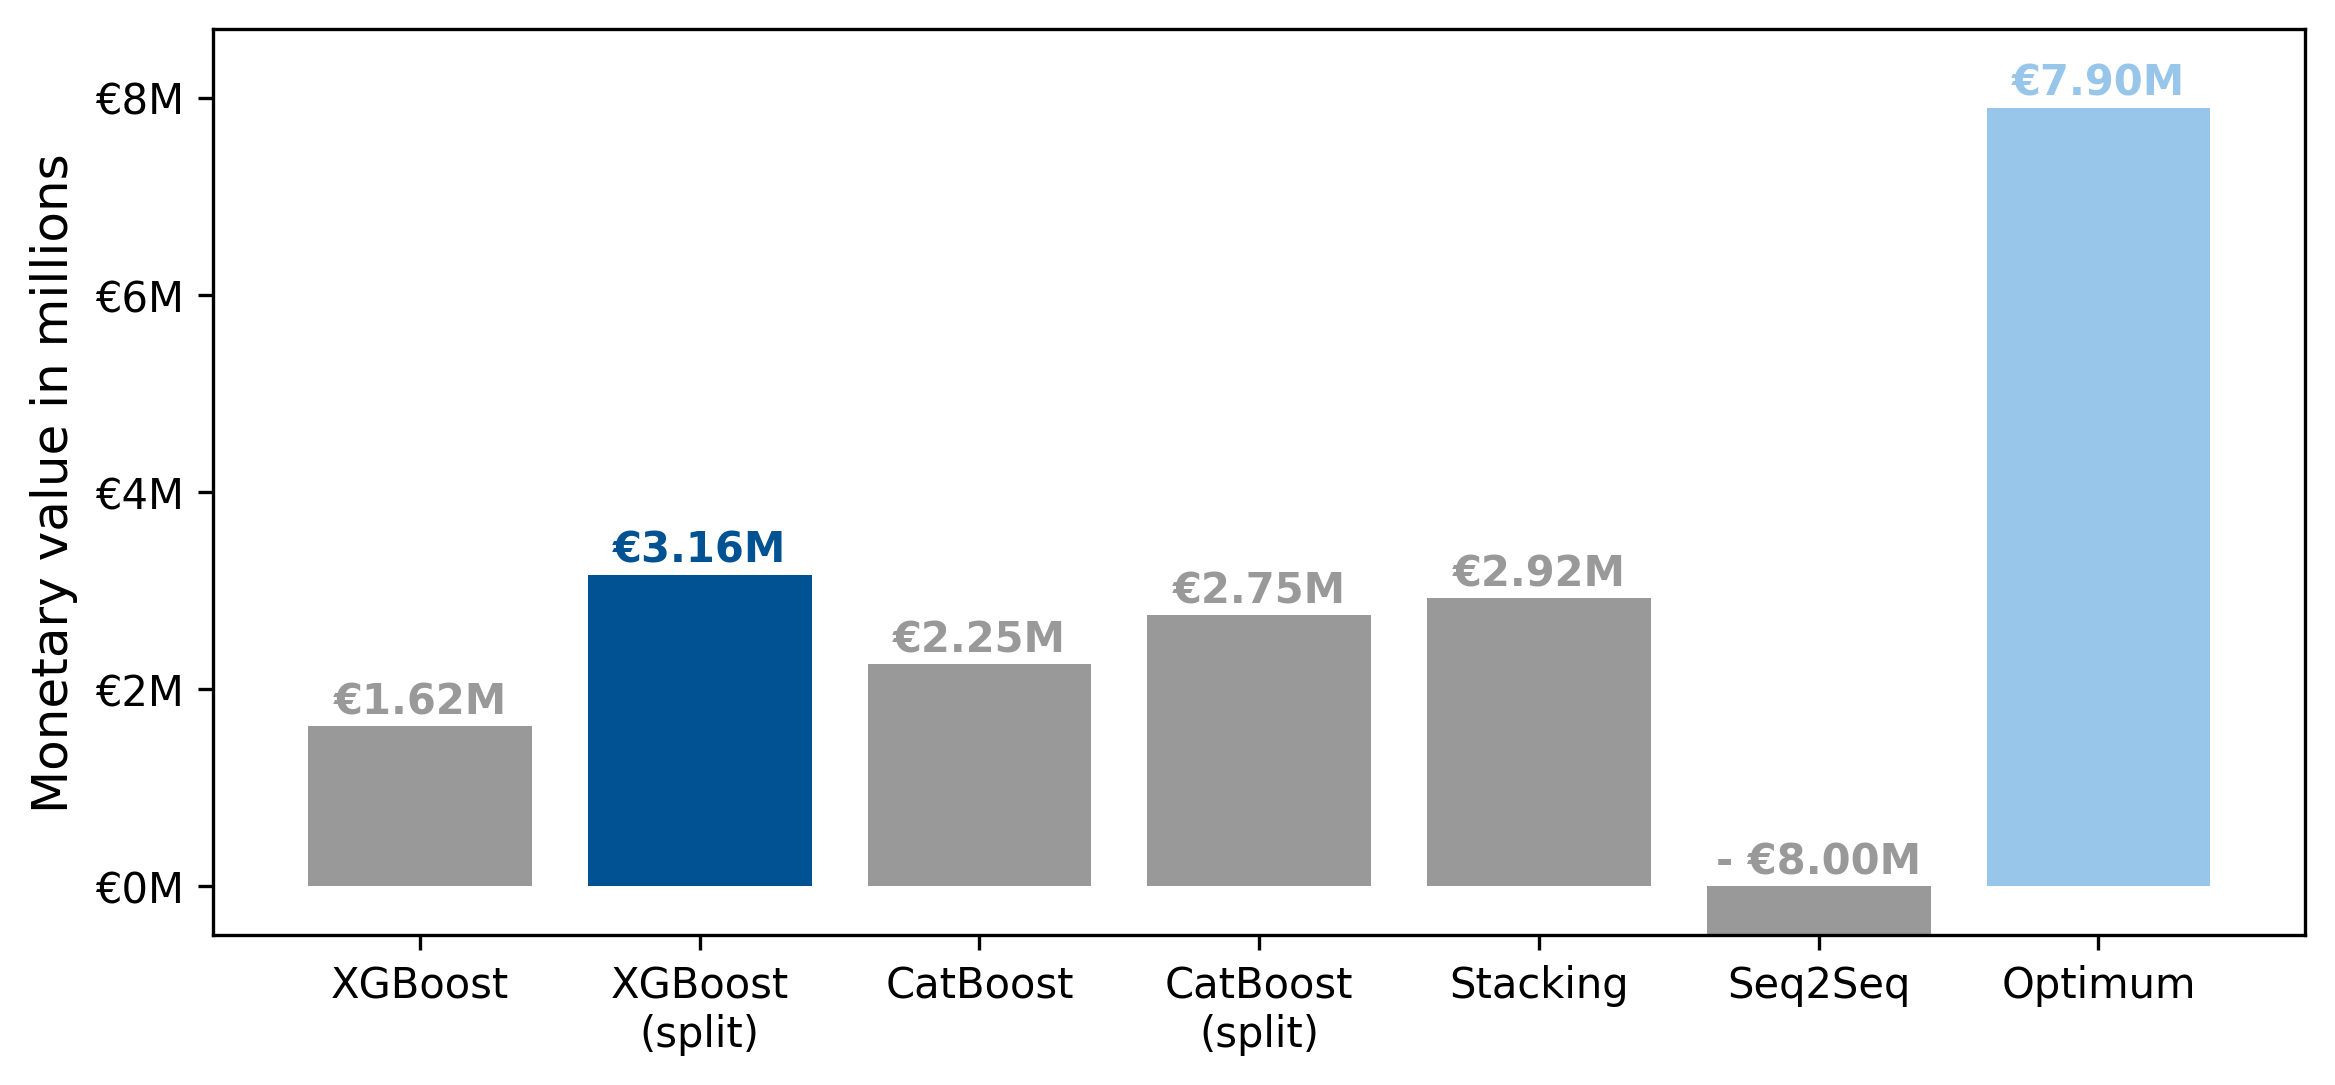

In [54]:
formatter = FuncFormatter(millions)

x = np.arange(len(results))

fig, ax = plt.subplots(figsize=(9, 4))
ax.yaxis.set_major_formatter(formatter)
plt.bar(x, values, color=colors)
plt.xticks(x, models)
plt.ylabel("Monetary value in millions", fontsize=12)
plt.ylim(bottom=-0.5)

# Add values to the bars
for i, v in enumerate(values):
  y = v + 0.25 if v > 0 else 0.25
  minus = "- " if v < 0 else ""
  ax.text(i, y, f"{minus}€{abs(v):.2f}M", color=colors[i], fontweight='bold', va='center', ha='center')

plt.show()

# Plot showing data splitting

In [42]:
import matplotlib.dates as mdates
import datetime as dt

In [43]:
phase1 = 2
phase2 = 1

In [44]:
train_start = dt.datetime(2018, 1, 1)
val_start = dt.datetime(2018, 5, 19)
test1_start = dt.datetime(2018, 6, 2)
test2_start = dt.datetime(2018, 6, 16)
test2_end = dt.datetime(2018, 6, 30)

val_final_start = dt.datetime(2018, 6, 16)
test_final_start = dt.datetime(2018, 6, 30)
test_final_end = dt.datetime(2018, 7, 13)

In [45]:
# train = mdates.drange(train_start, val_start, dt.timedelta(days=1))
# val = mdates.drange(val_start, test1_start, dt.timedelta(days=1))
# test1 = mdates.drange(test1_start, test2_start, dt.timedelta(days=1))
# test2 = mdates.drange(test2_start, test2_end, dt.timedelta(days=1))

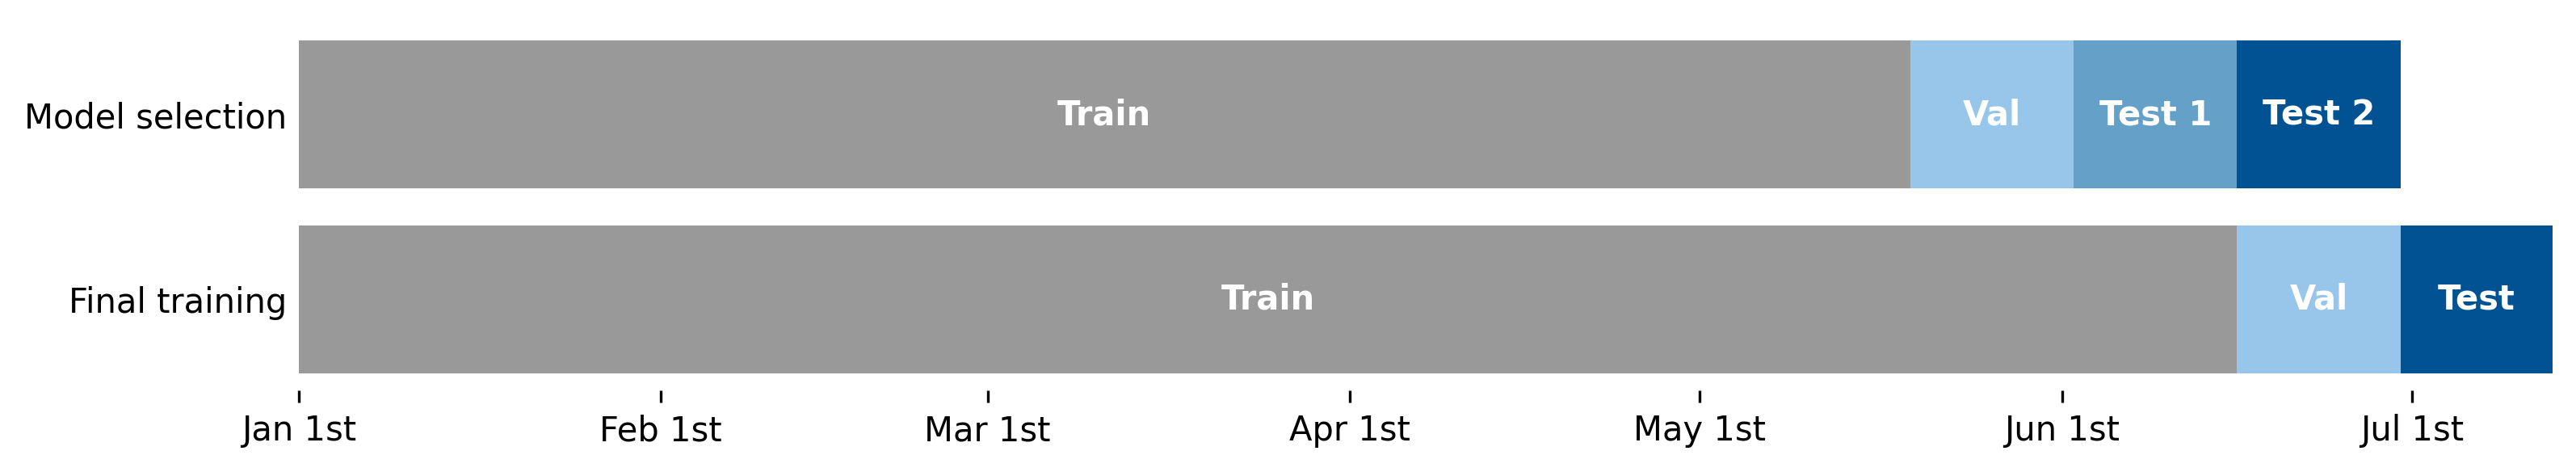

In [46]:
def plot_period(start, end, y, color, label=""):
  x0 = mdates.date2num(start)
  xd = mdates.date2num(end) - x0
  plt.barh(y, xd, left=x0, color=color)
  center = x0 + xd/2
  ax.text(center, y, label, va="center", ha="center", color="#fff", 
          fontweight='bold') #, fontsize=12)

# def months(x, pos):
#   return str(type(x)) # f"€{x:.0f} M"

# formatter = FuncFormatter(months)

fig, ax = plt.subplots(figsize=(12, 2))
plt.xlim((train_start, test_final_end))
# ax.xaxis.set_major_formatter(formatter)

plot_period(train_start, val_start, phase1, gray, "Train")
plot_period(val_start, test1_start, phase1, lighterblue, "Val")
plot_period(test1_start, test2_start, phase1, lightblue, "Test 1")
plot_period(test2_start, test2_end, phase1, darkblue, "Test 2")

plot_period(train_start, val_final_start, phase2, gray, "Train")
plot_period(val_final_start, test_final_start, phase2, lighterblue, "Val")
plot_period(test_final_start, test_final_end, phase2, darkblue, "Test")

plt.yticks([phase1, phase2], ["Model selection", "Final training"])
plt.xticks(ax.get_xticks(), ["Jan 1st", "Feb 1st", "Mar 1st", "Apr 1st", "May 1st", "Jun 1st", "Jul 1st"])

plt.box(on=None)
ax.tick_params(axis='y', which='both', length=0)

plt.show()